In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import torch
from model_builder_with_conf import create_dnn_model, create_cnn_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from model_builder_with_conf import SimpleDNN, SimpleCNN
import torch.nn.functional as F
from plotter_standard import visualize_tissue_image_with_samples, visualize_tissue_image_with_samples_color_labels

#input_csv = "patches_with_majority_pathology.csv"
input_csv = "WSI_patch_embeddings_standard-224_adenocarcinoma_leiden_0.3_training-data_old.csv"
df = pd.read_csv(input_csv)


# Settings: 
do_pca = True
pca_components = 10
pca_dimensions = [0.8, 0.85, 0.9, 0.95]
epochs = 1
output_base_path = "models/"
output_path_extra_desciptor = "" # leave empyt if not needed; 
ebbeding_dim = 1536

Get pathology training data

In [2]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

feature_cols = [str(i) for i in range(1536)]
X = df[feature_cols].values.astype(np.float32)

scaler = StandardScaler()
X = scaler.fit_transform(X).astype(np.float32)
y = LabelEncoder().fit_transform(df['label'].values).astype(np.int64)
labelEncoder = LabelEncoder().fit(df['label'].values)

# Extract confidence scores - required column
if 'confidence' not in df.columns:
    raise ValueError("Expected 'confidence' column not found in the dataset!")

confidence_scores = df['confidence'].values.astype(np.float32)
print(f"Using confidence scores. Range: {confidence_scores.min():.3f} - {confidence_scores.max():.3f}")
print(f"Mean confidence: {confidence_scores.mean():.3f}")

#without pca
dnn_output_path = "models/dnn_pathology_model.pth"
df = pd.read_csv(input_csv)
X_pcaList = []
for d in pca_dimensions:
# Initialize PCA with the specified number of components
    pca = PCA(n_components=pca_components)
    X_pcaList.append(pca.fit_transform(X))

Using confidence scores. Range: 0.017 - 1.000
Mean confidence: 0.638


Train DNN model

In [3]:
dnn_list = []
acc_list = []
if do_pca:
    print("Using PCA for dimensionality reduction...")
    for i, X_pca in enumerate(X_pcaList):
        print(f"Shape of PCA transformed data: {X_pca.shape}")
        X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)
        
        # Split confidence scores
        conf_train, conf_test = train_test_split(confidence_scores, test_size=0.2, random_state=42, stratify=y)
        
        dnn_output_path = f"{output_base_path}/dnn_pathology_model_pca_{pca_components}.pth"
        model,acc = create_dnn_model(X_train, X_test, y_train, y_test, dnn_output_path, labelEncoder, 
                                   inputDim=pca_components, epochs=epochs, 
                                   train_weights=conf_train, test_weights=conf_test)
        dnn_list.append(model)
        acc_list.append(acc)
        print(f"Training set size: {X_train.shape[0]}")
        print(f"Testing set size: {X_test.shape[0]}")
        print("")
        
# Once without PCA        
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Split confidence scores
conf_train, conf_test = train_test_split(confidence_scores, test_size=0.2, random_state=42, stratify=y)

dnn_output_path = f"{output_base_path}/dnn_pathology_model_without_pca.pth"
dnn_without_pca, acc_without_pca = create_dnn_model(X_train, X_test, y_train, y_test, dnn_output_path, labelEncoder, 
                                                  inputDim=ebbeding_dim, epochs=epochs,
                                                  train_weights=conf_train, test_weights=conf_test)
print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

Using PCA for dimensionality reduction...
Shape of PCA transformed data: (6551, 10)
Training DNN with confidence-based sample weights
DNN: Epoch 1 completed. Average Loss: 0.6465
DNN Accuracy: 0.733
Training set size: 5240
Testing set size: 1311

Shape of PCA transformed data: (6551, 10)
Training DNN with confidence-based sample weights
DNN: Epoch 1 completed. Average Loss: 0.6621
DNN Accuracy: 0.733
Training set size: 5240
Testing set size: 1311

Shape of PCA transformed data: (6551, 10)
Training DNN with confidence-based sample weights
DNN: Epoch 1 completed. Average Loss: 0.6542
DNN Accuracy: 0.731
Training set size: 5240
Testing set size: 1311

Shape of PCA transformed data: (6551, 10)
Training DNN with confidence-based sample weights
DNN: Epoch 1 completed. Average Loss: 0.6540
DNN Accuracy: 0.731
Training set size: 5240
Testing set size: 1311

Training DNN with confidence-based sample weights
DNN: Epoch 1 completed. Average Loss: 0.5327
DNN Accuracy: 0.798
Training set size: 5240

Train CNN model

In [4]:
cnn_output_path = "models/cnn_pathology_model.pth" # not needed anymore since we dont save the models externally
create_cnn_model(X_train, X_test, y_train, y_test, cnn_output_path, labelEncoder, epochs=epochs,
                train_weights=conf_train, test_weights=conf_test)

Training CNN with confidence-based sample weights
CNN: Epoch 1 completed. Average Loss: 0.5334
CNN Accuracy: 0.793


(SimpleCNN(
   (conv): Sequential(
     (0): Conv1d(1, 16, kernel_size=(5,), stride=(1,), padding=(2,))
     (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU()
     (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (4): Dropout(p=0.5, inplace=False)
     (5): Conv1d(16, 32, kernel_size=(5,), stride=(1,), padding=(2,))
     (6): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (7): ReLU()
     (8): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (9): Dropout(p=0.5, inplace=False)
   )
   (fc): Sequential(
     (0): Linear(in_features=12288, out_features=128, bias=True)
     (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU()
     (3): Dropout(p=0.5, inplace=False)
     (4): Linear(in_features=128, out_features=8, bias=True)
   )
 ),
 0.7925247902364607)

~~Load trained models and perform dummy predictions~~ We dont extrnaly save the models


In [5]:
# # Load DNN model
# if do_pca:
#     input_dim = pca_components
# else:
#     input_dim = 1536
# dnn_list = []

# #for each pca_components in pca_dimensions load all models
# for pca_components in pca_dimensions:
#     dnn_output_path = f"{output_base_path}dnn_pathology_model_pca_{pca_components}.pth"
#     dnn_model = SimpleDNN(input_dim, len(np.unique(y_train)))
#     checkpoint_dnn = torch.load(dnn_output_path)
#     dnn_model.load_state_dict(checkpoint_dnn.get("state_dict", checkpoint_dnn))
#     dnn_list.append(dnn_model)
#     dnn_model.eval()


    
# # dnn_model = SimpleDNN(input_dim, len(np.unique(y_train)))
# # checkpoint_dnn = torch.load(dnn_output_path)
# # dnn_model.load_state_dict(checkpoint_dnn.get("state_dict", checkpoint_dnn))
# # dnn_model.eval()


In [6]:

# # Load CNN model
# cnn_model = SimpleCNN(len(np.unique(y_train)))
# checkpoint_cnn = torch.load(cnn_output_path)
# cnn_model.load_state_dict(checkpoint_cnn.get("state_dict", checkpoint_cnn))
# cnn_model.eval()

In [7]:
# # Load saved label classes from the DNN model checkpoint
# checkpoint = torch.load(dnn_output_path)
# if "label_classes" in checkpoint:
#     original_labels = np.array(checkpoint["label_classes"])

# # One sample demo predictions of DNN model
# sample_input = torch.tensor(X_test[0]).unsqueeze(0)  # Add batch dimension
# dnn_output = dnn_model(sample_input)
# dnn_pred_enc = F.softmax(dnn_output, dim=1).argmax(dim=1).item()
# dnn_pred_label = original_labels[dnn_pred_enc]
# true_label = original_labels[y_test[0]]
# print(f"DNN model prediction: {dnn_pred_label} (encoded: {dnn_pred_enc}), True: {true_label} (encoded: {y_test[0]})")

# # One sample demo predictions of CNN model
# sample_input = torch.tensor(X_test[0]).unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
# #cnn_output = cnn_model(sample_input)
# #cnn_pred_enc = F.softmax(cnn_output, dim=1).argmax(dim=1).item()
# #cnn_pred_label = original_labels[cnn_pred_enc]
# #print(f"CNN model prediction: {cnn_pred_label} (encoded: {cnn_pred_enc}), True: {true_label} (encoded: {y_test[0]})")


In [8]:
print(df.columns)

Index(['Patch_X', 'Patch_Y', '0', '1', '2', '3', '4', '5', '6', '7',
       ...
       '1528', '1529', '1530', '1531', '1532', '1533', '1534', '1535', 'label',
       'confidence'],
      dtype='object', length=1540)


## Visualize Sample points

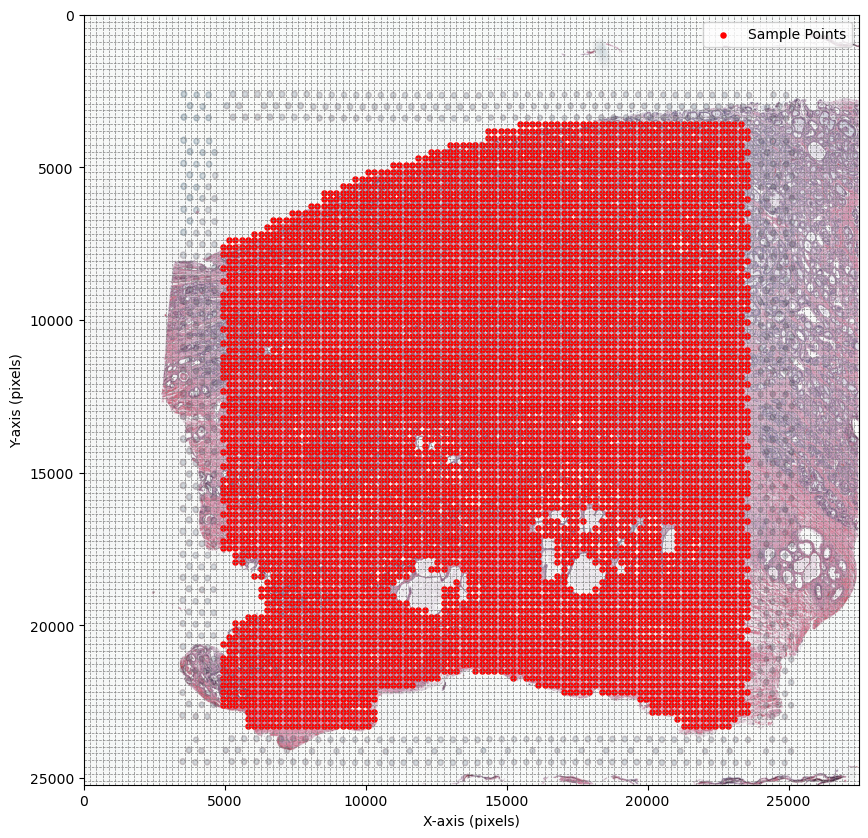

In [9]:
image_path = "spatial/tissue_hires_image.png"
visualize_tissue_image_with_samples(image_path, df, 27482, 25219)



## Visualize Ground Truth Labels on Tissue Image

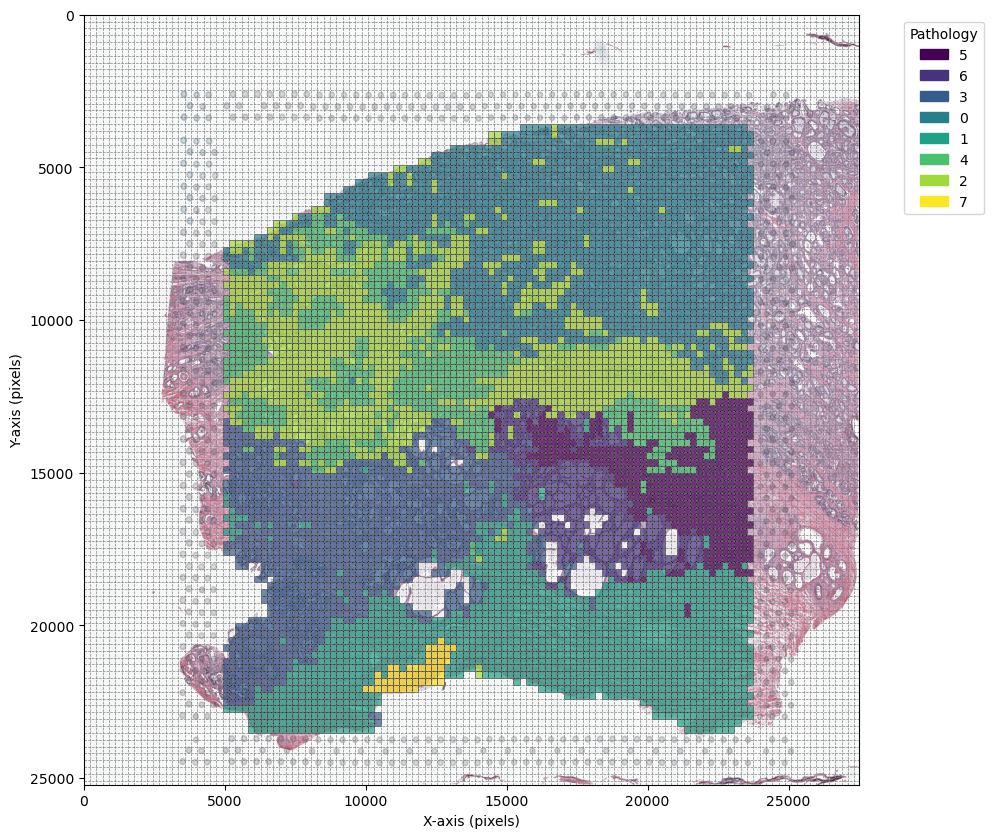

In [10]:
image_path = "spatial/tissue_hires_image.png"
visualize_tissue_image_with_samples_color_labels(image_path, df, 27482, 25219)


## Visualize predictions from DNN

In [11]:
original_labels = labelEncoder.classes_.tolist()

# Get predictions for all data
list_of_prediced_labels = []
X_tensor = torch.tensor(X_pca).float()
list_of_df_predicted_dnn = []
list_of_model_names = []
for i,dnn_model in enumerate(dnn_list):
    # for each dnn_model in dnn_list ceate a df with Patch X and Patch Y as columns and then a predicted label column
    X_tensor = torch.tensor(X_pcaList[i]).float()
    with torch.no_grad():
        dnn_outputs_temp = dnn_model(X_tensor)
        temp = F.softmax(dnn_outputs_temp, dim=1).argmax(dim=1)
        # list comphehension of predicted labels
        prediced_labels =  [original_labels[label] for label in temp.numpy()]
        df_predicted_dnn = df[['Patch_X', 'Patch_Y']].copy()
        df_predicted_dnn['label'] = prediced_labels
        list_of_prediced_labels.append(prediced_labels)
        # Append the dataframe to the list
        list_of_model_names.append(f'dnn_pca_{i+1}')
        df_predicted_dnn['pca_components'] = pca_components
        list_of_df_predicted_dnn.append(df_predicted_dnn)






In [ ]:
from sklearn.metrics import adjusted_rand_score, f1_score, roc_auc_score

# calculate the ARIC score for each model
# Calculate ARI, F1 and ROCauc for each PCA model
ari_score_list = []
f1_score_list = []
roc_auc_score_list = []
for i, preds in enumerate(list_of_prediced_labels):
    roc = roc_auc_score(y, preds, multi_class='ovr')  # Assuming y is the true labels
    f1 = f1_score(y, preds, average='weighted')  # Assuming y is the true labels
    ari_score = adjusted_rand_score(y, preds)# y is the true labels
    ari_score_list.append(ari_score)
    f1_score_list.append(f1)
    roc_auc_score_list.append(roc)
    




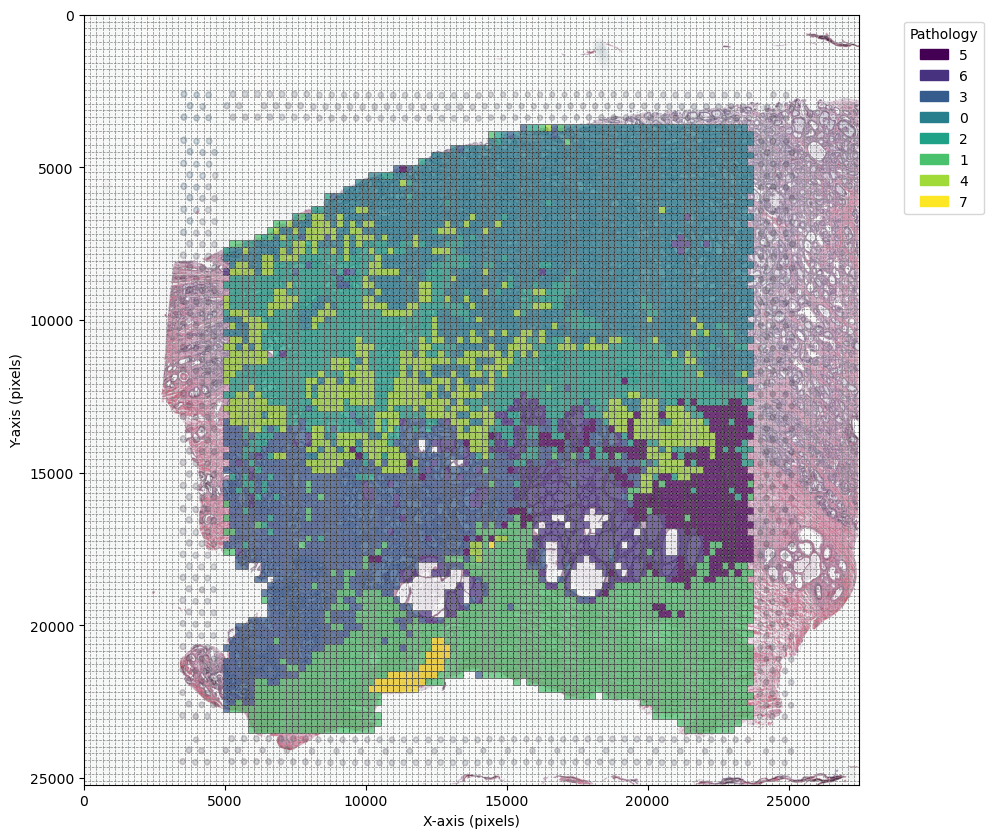

In [13]:

# now visulize without PCA
X_tensor = torch.tensor(X).float()
with torch.no_grad():
	dnn_outputs = dnn_without_pca(X_tensor)
	dnn_preds_enc = F.softmax(dnn_outputs, dim=1).argmax(dim=1)
predicted_labels = [original_labels[label] for label in dnn_preds_enc.numpy()]
image_path = "spatial/tissue_hires_image.png"
df_predicted_dnn = df[['Patch_X', 'Patch_Y']].copy()
df_predicted_dnn['label'] = predicted_labels

image_path = "spatial/tissue_hires_image.png"
visualize_tissue_image_with_samples_color_labels(image_path, df_predicted_dnn, 27482, 25219)







